In [49]:
import xgboost as xgb

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [51]:
train = pd.read_csv('train_data_with_feature.csv')

In [52]:
train = train.fillna(0)

In [53]:
y = train['label']

In [54]:
X = train[['average_AoA_Kup_lem',
       'percentage_of_basic_words', 'average_concreteness',
       'average_percentage_known']]

In [128]:
extra = pd.read_csv('train_data_bert_label.csv')

In [144]:
train['bert'] = extra['predicted_label'] * 100000

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
dtrain = xgb.DMatrix(X_train, label = y_train)

In [58]:
dvalid = xgb.DMatrix(X_test, label = y_test)

### cross validation

In [61]:
gridsearch_params = [
    (max_depth, min_child_weight, eta)
    for max_depth in [5, 15, 20, 25, 30]
    for min_child_weight in range(5,8)
    for eta in [0.5, 0.6, 0.7, 0.8, 0.9]
]

In [63]:
min_error = float("Inf")
n_estimators = 5
best_params = None
for max_depth, min_child_weight, eta in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}, eta = {}".format(
                             max_depth,
                             min_child_weight, eta))
    param_dist['max_depth'] = max_depth
    param_dist['min_child_weight'] = min_child_weight  
    param_dist['eta'] = eta
    cv_results = xgb.cv(
        param_dist,
        dtrain,
        num_boost_round=n_estimators,
        seed=42,
        nfold=5,
        metrics={'error'}
    ) 
    mean_error = cv_results['test-error-mean'].min()
    boost_rounds = cv_results['test-error-mean'].argmin()
    print("\terror {} for {} rounds".format(mean_error, boost_rounds))
    if mean_error < min_error:
        min_error = mean_error
        best_params = (max_depth,min_child_weight, eta)
    print("Best params: {}, {}, {},error: {}".format(best_params[0], best_params[1], best_params[2], min_error))

CV with max_depth=5, min_child_weight=5, eta = 0.5
	error 0.37595 for 4 rounds
Best params: 5, 5, 0.5,error: 0.37595
CV with max_depth=5, min_child_weight=5, eta = 0.6
	error 0.3746876 for 4 rounds
Best params: 5, 5, 0.6,error: 0.3746876
CV with max_depth=5, min_child_weight=5, eta = 0.7
	error 0.37460039999999994 for 4 rounds
Best params: 5, 5, 0.7,error: 0.37460039999999994
CV with max_depth=5, min_child_weight=5, eta = 0.8
	error 0.375821 for 4 rounds
Best params: 5, 5, 0.7,error: 0.37460039999999994
CV with max_depth=5, min_child_weight=5, eta = 0.9
	error 0.37500199999999995 for 4 rounds
Best params: 5, 5, 0.7,error: 0.37460039999999994
CV with max_depth=5, min_child_weight=6, eta = 0.5
	error 0.37595 for 4 rounds
Best params: 5, 5, 0.7,error: 0.37460039999999994
CV with max_depth=5, min_child_weight=6, eta = 0.6
	error 0.37463959999999996 for 4 rounds
Best params: 5, 5, 0.7,error: 0.37460039999999994
CV with max_depth=5, min_child_weight=6, eta = 0.7
	error 0.37457039999999997 fo

	error 0.36215639999999993 for 4 rounds
Best params: 30, 5, 0.5,error: 0.3576664
CV with max_depth=30, min_child_weight=5, eta = 0.9
	error 0.36365300000000006 for 4 rounds
Best params: 30, 5, 0.5,error: 0.3576664
CV with max_depth=30, min_child_weight=6, eta = 0.5
	error 0.3577654 for 4 rounds
Best params: 30, 5, 0.5,error: 0.3576664
CV with max_depth=30, min_child_weight=6, eta = 0.6
	error 0.3613496 for 4 rounds
Best params: 30, 5, 0.5,error: 0.3576664
CV with max_depth=30, min_child_weight=6, eta = 0.7
	error 0.36251639999999996 for 4 rounds
Best params: 30, 5, 0.5,error: 0.3576664
CV with max_depth=30, min_child_weight=6, eta = 0.8
	error 0.36388380000000004 for 4 rounds
Best params: 30, 5, 0.5,error: 0.3576664
CV with max_depth=30, min_child_weight=6, eta = 0.9
	error 0.36779799999999996 for 4 rounds
Best params: 30, 5, 0.5,error: 0.3576664
CV with max_depth=30, min_child_weight=7, eta = 0.5
	error 0.35887520000000006 for 4 rounds
Best params: 30, 5, 0.5,error: 0.3576664
CV with 

### Training

### With only manually extracted features

In [145]:
param_dist = {'objective':'binary:logistic', 'n_estimators':100, 'max_depth':15}
param_dist['max_depth'] = best_params[0]
param_dist['min_child_weight'] = best_params[1]  
param_dist['eta'] = best_params[2]
clf = xgb.XGBModel(**param_dist)

In [146]:
clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='error',
        verbose=True)

[0]	validation_0-error:0.18157	validation_1-error:0.19451
[1]	validation_0-error:0.17504	validation_1-error:0.18417
[2]	validation_0-error:0.17241	validation_1-error:0.18269
[3]	validation_0-error:0.16954	validation_1-error:0.18185
[4]	validation_0-error:0.16723	validation_1-error:0.18174
[5]	validation_0-error:0.16224	validation_1-error:0.18221
[6]	validation_0-error:0.15926	validation_1-error:0.18287
[7]	validation_0-error:0.15618	validation_1-error:0.18279
[8]	validation_0-error:0.15327	validation_1-error:0.18313
[9]	validation_0-error:0.15135	validation_1-error:0.18322
[10]	validation_0-error:0.14776	validation_1-error:0.18384
[11]	validation_0-error:0.14481	validation_1-error:0.18430
[12]	validation_0-error:0.14258	validation_1-error:0.18478
[13]	validation_0-error:0.14091	validation_1-error:0.18471
[14]	validation_0-error:0.13869	validation_1-error:0.18499
[15]	validation_0-error:0.13809	validation_1-error:0.18515
[16]	validation_0-error:0.13724	validation_1-error:0.18522
[17]	va

XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0, gpu_id=-1,
         interaction_constraints='', learning_rate=0.5, max_delta_step=0,
         max_depth=30, min_child_weight=5, monotone_constraints='()', n_jobs=8,
         num_parallel_tree=1, objective='binary:logistic', predictor='auto',
         random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
         subsample=1, tree_method='exact', validate_parameters=1)

In [147]:
features = ['average_AoA_Kup_lem',
       'percentage_of_basic_words', 'average_concreteness',
       'average_percentage_known']

In [85]:
print(features)

['average_AoA_Kup_lem', 'percentage_of_basic_words', 'average_concreteness', 'average_percentage_known']


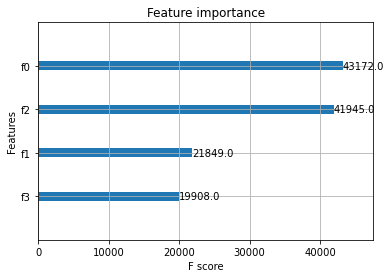

In [83]:
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(clf)
pyplot.show()

### With BERT feature

In [148]:
X = train[['average_AoA_Kup_lem',
       'percentage_of_basic_words', 'average_concreteness',
       'average_percentage_known', 'bert']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
param_dist['n_estimators'] = 20
clf = xgb.XGBModel(**param_dist)
clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='error',
        verbose=True)

[0]	validation_0-error:0.18157	validation_1-error:0.19451
[1]	validation_0-error:0.17504	validation_1-error:0.18417
[2]	validation_0-error:0.17241	validation_1-error:0.18269
[3]	validation_0-error:0.16954	validation_1-error:0.18185
[4]	validation_0-error:0.16723	validation_1-error:0.18174
[5]	validation_0-error:0.16224	validation_1-error:0.18221
[6]	validation_0-error:0.15926	validation_1-error:0.18287
[7]	validation_0-error:0.15618	validation_1-error:0.18279
[8]	validation_0-error:0.15327	validation_1-error:0.18313
[9]	validation_0-error:0.15135	validation_1-error:0.18322
[10]	validation_0-error:0.14776	validation_1-error:0.18384
[11]	validation_0-error:0.14481	validation_1-error:0.18430
[12]	validation_0-error:0.14258	validation_1-error:0.18478
[13]	validation_0-error:0.14091	validation_1-error:0.18471
[14]	validation_0-error:0.13869	validation_1-error:0.18499
[15]	validation_0-error:0.13809	validation_1-error:0.18515
[16]	validation_0-error:0.13724	validation_1-error:0.18522
[17]	va

XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0, gpu_id=-1,
         interaction_constraints='', learning_rate=0.5, max_delta_step=0,
         max_depth=30, min_child_weight=5, monotone_constraints='()',
         n_estimators=20, n_jobs=8, num_parallel_tree=1,
         objective='binary:logistic', predictor='auto', random_state=0,
         reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
         tree_method='exact', validate_parameters=1)

In [180]:
features = ['average_AoA_Kup_lem',
       'percentage_of_basic_words', 'average_concreteness',
       'average_percentage_known', 'bert']
print(features)

['average_AoA_Kup_lem', 'percentage_of_basic_words', 'average_concreteness', 'average_percentage_known', 'bert']


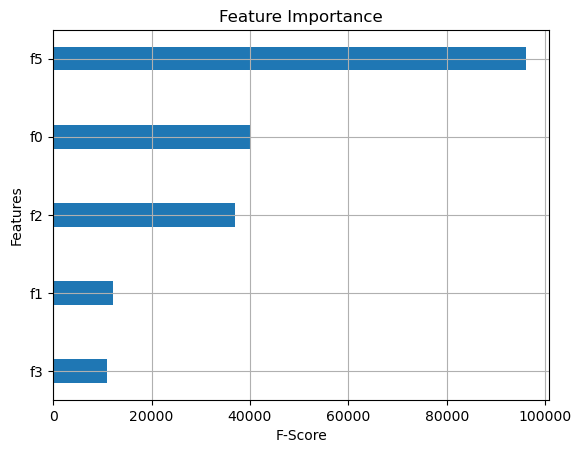

In [179]:
# plot feature importance
plot_importance(clf)
pyplot.show()

### Generate Result File

In [66]:
test = pd.read_csv('test_data_with_feature.csv')

In [105]:
extra = pd.read_csv('test_data_bert_label.csv')

In [67]:
test = test.fillna(0)

In [110]:
test['bert'] = extra['label']

In [68]:
X = test[['average_AoA_Kup_lem',
       'percentage_of_basic_words', 'average_concreteness',
       'average_percentage_known']]
X = scaler.transform(X)

In [69]:
dtest = xgb.DMatrix(X)

In [113]:
X = test[['average_AoA_Kup_lem',
       'percentage_of_basic_words', 'average_concreteness',
       'average_percentage_known','bert']]

In [114]:
ypred = clf.predict(X)

In [115]:
result = ypred > 0.5

In [116]:
result = pd.DataFrame(result)

In [117]:
result[0] = result[0].astype(int)

In [118]:
result.columns = ['label']

In [119]:
result.index.name = 'id'

In [120]:
result.to_csv('testing.csv')

### Sensitivity analysis

In [185]:
param_dist = {'objective':'binary:logistic', 'n_estimators':20, 'max_depth':15}
param_dist['max_depth'] = best_params[0]
param_dist['min_child_weight'] = best_params[1]  
param_dist['eta'] = best_params[2]
clf = xgb.XGBModel(**param_dist)

In [188]:
X = train[['average_AoA_Kup_lem',
       'percentage_of_basic_words', 'average_concreteness',
       'average_percentage_known', 'bert']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [189]:
param_dist['n_estimators'] = 30
clf = xgb.XGBModel(**param_dist)
clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='error',
        verbose=True)

[0]	validation_0-error:0.18157	validation_1-error:0.19451
[1]	validation_0-error:0.17504	validation_1-error:0.18417
[2]	validation_0-error:0.17241	validation_1-error:0.18269
[3]	validation_0-error:0.16954	validation_1-error:0.18185
[4]	validation_0-error:0.16723	validation_1-error:0.18174
[5]	validation_0-error:0.16224	validation_1-error:0.18221
[6]	validation_0-error:0.15926	validation_1-error:0.18287
[7]	validation_0-error:0.15618	validation_1-error:0.18279
[8]	validation_0-error:0.15327	validation_1-error:0.18313
[9]	validation_0-error:0.15135	validation_1-error:0.18322
[10]	validation_0-error:0.14776	validation_1-error:0.18384
[11]	validation_0-error:0.14481	validation_1-error:0.18430
[12]	validation_0-error:0.14258	validation_1-error:0.18478
[13]	validation_0-error:0.14091	validation_1-error:0.18471
[14]	validation_0-error:0.13869	validation_1-error:0.18499
[15]	validation_0-error:0.13809	validation_1-error:0.18515
[16]	validation_0-error:0.13724	validation_1-error:0.18522
[17]	va

XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0, gpu_id=-1,
         interaction_constraints='', learning_rate=0.5, max_delta_step=0,
         max_depth=30, min_child_weight=5, monotone_constraints='()',
         n_estimators=30, n_jobs=8, num_parallel_tree=1,
         objective='binary:logistic', predictor='auto', random_state=0,
         reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
         tree_method='exact', validate_parameters=1)

[]

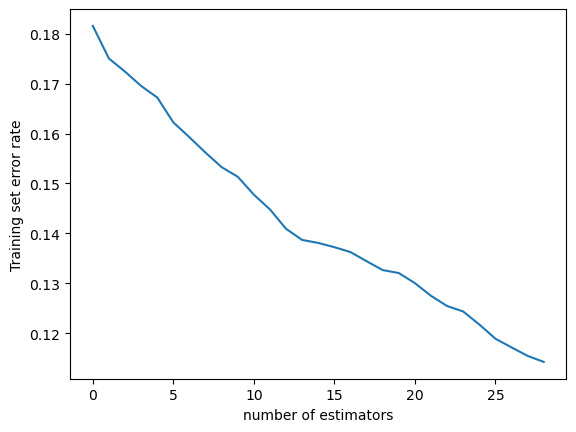

In [200]:
train_set_arr = [0.18157, 0.17504, 0.17241, 0.16954, 0.16723, 0.16224, 0.15926, 0.15618, 0.15327, 0.15135, 0.14776, 0.14481, 0.14091, 0.13869, 0.13809, 0.13724, 0.13626, 0.13443, 0.13265, 0.13206, 0.13004, 0.12749, 0.12545, 0.12435, 0.12175, 0.11890, 0.11716, 0.11546, 0.11425]

plt.plot(train_set_arr)
plt.xlabel('number of estimators')
plt.ylabel('Training set error rate')
plt.plot()

[]

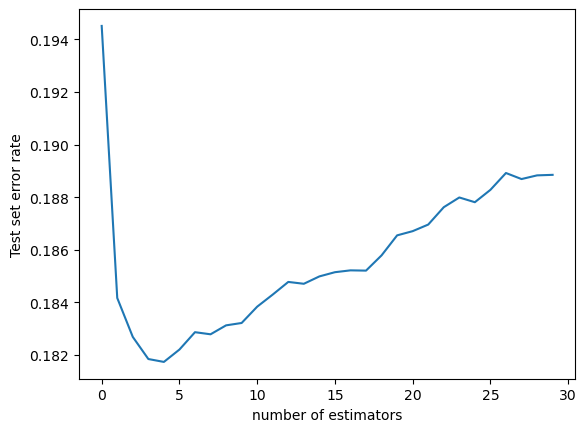

In [203]:
test_set_arr = [0.19451, 0.18417, 0.18269, 0.18185, 0.18174, 0.18221, 0.18287, 0.18279, 0.18313, 0.18322, 0.18384, 0.18430, 0.18478, 0.18471, 0.18499, 0.18515, 0.18522, 0.18521, 0.18579, 0.18655, 0.18671, 0.18696, 0.18762, 0.18799, 0.18781, 0.18828, 0.18892, 0.18869, 0.18883, 0.18885]
plt.plot(test_set_arr)
plt.xlabel('number of estimators')
plt.ylabel('Test set error rate')
plt.plot()